In [17]:
!pip install gymnasium
!pip install torch torchvision torchaudio
!pip install bindsnet


In [18]:
import gymnasium as gym
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
from keras import Sequential
from collections import deque
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
import random
from keras.layers import Dense, Activation
from keras.initializers import RandomNormal
from keras import backend as K
from collections import deque
import random
import numpy as np
import torch
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection



In [19]:
dtype = torch.float
device = torch.device("cpu")
np.random.seed(0)
env = gym.make('CartPole-v1')

episode: 0/100, score: 19.0
episode: 1/100, score: 40.0
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
episode: 2/100, score: 19.0
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shape of q_values: (2,)
Shap

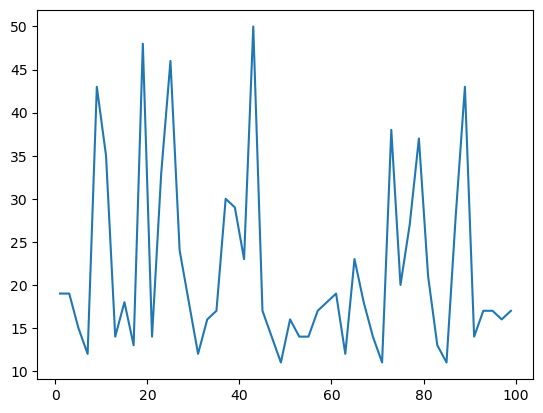

In [34]:

class DQN:
    """ Implementation of deep q learning algorithm using BindsNET for SNN simulation. """

    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self): # SNN model with BindsNET
        network = Network()
        input_layer = Input(n=self.state_space) # input layer with state space size
        output_layer = LIFNodes(n=self.action_space) #output layer with action space size
        network.add_layer(input_layer, name='input')
        network.add_layer(output_layer, name='output')
        input_output = Connection(input_layer, output_layer, update_rule=None, w=torch.randn(self.state_space, self.action_space))
        network.add_connection(input_output, source='input', target='output') # connecting the two layers using feedforward connections
        network.compile()
        return network

    def remember(self, state, action, reward, next_state, done): #store the experience
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state): #select an action based on current state
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space) #exploration
        state_tensor = torch.from_numpy(state).float()
        self.model.layers['input'].s = state_tensor
        self.model.run(time=1)
        return np.argmax(self.model.layers['output'].s.numpy()) #exploitation
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state_tensor = torch.from_numpy(next_state).float()
                self.model.layers['input'].s = next_state_tensor
                self.model.run(time=1, inputs={'input': self.model.layers['input'].s})
                next_state_value = np.max(self.model.layers['output'].s.numpy()) #choose the action with the maximum Q_value
                target = reward + self.gamma * next_state_value
        state_tensor = torch.from_numpy(state).float()
        self.model.layers['input'].s = state_tensor
        self.model.run(time=1, inputs={'input': self.model.layers['input'].s})
        q_values = self.model.layers['output'].s.numpy()
        q_values = q_values.reshape(-1)  # Reshape q_values to remove extra dimension
        print("Shape of q_values:", q_values.shape)  # Print the shape of q_values
        q_values[action] = target # update the q-value for the current state
        self.model.layers['output'].s = torch.from_numpy(q_values) # update the output layer




def train_dqn(episode):
    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state_tuple = env.reset()
        state = state_tuple[0]  # Extract the NumPy array part of the state tuple
        state = np.array(state)  # Convert state to a NumPy array
        state = np.reshape(state, (1, -1))  # Reshape state to (1, n) shape
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            env.render()
            action = agent.act(state) #select the action based on the current state
            step_result = env.step(action)
            next_state, reward, done, _ = step_result[:4] #select the relevant information
            next_state = np.array(next_state)  # Convert next_state to a NumPy array
            next_state = np.reshape(next_state, (1, -1))  # Reshape next_state to (1, n) shape
            score += reward #update reward
            agent.remember(state, action, reward, next_state, done) #store in the memory
            state = next_state
            agent.replay() #train using the previous experience 
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score) # score of each episode
    return loss


if __name__ == '__main__':
    ep = 100
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()

    # Close the environment after training
    env.close()
